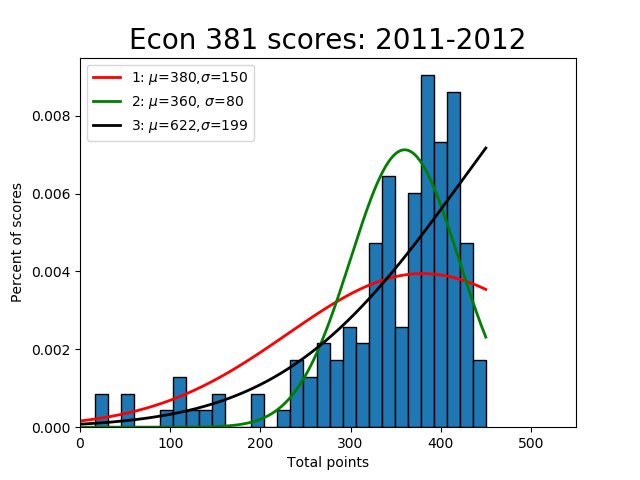

In [1]:
import numpy as np
import scipy.stats as sts
import requests
import matplotlib.pyplot as plt
import pandas as pd
# this is a perfect example from https://notes.quantecon.org/submission/5b3b1856b9eab00015b89f90

# while I tend to code my own gT(theta) and W 
# to form an original 2SGMM and iterated GMM
import requests
from IPython.display import Image

# Download and save the data file MLEplots.png
url = ('https://raw.githubusercontent.com/rickecon/Notebooks/' +
       'master/GMM/images/MLEplots.png')
image_file = requests.get(url, allow_redirects=True)
open('MLEplots.png', 'wb').write(image_file.content)
Image("MLEplots.png")

In [2]:
# Download and save the data file Econ381totpts.txt
url = ('https://raw.githubusercontent.com/rickecon/Notebooks/' +
       'master/MLE/data/Econ381totpts.txt')
data_file = requests.get(url, allow_redirects=True)
open('Econ381totpts.txt', 'wb').write(data_file.content)

# Load the data as a NumPy array
pts = np.loadtxt('Econ381totpts.txt')

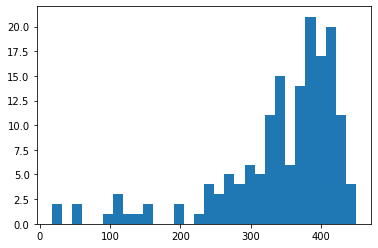

In [3]:
_= plt.hist(pts,bins=30)

In [4]:
# define the gT(theta)
# in this case theta is mu and sigma

#subjective set the underlying distribution is a kind of truncated normal distribution
import scipy
def pdf_truncated_normal( xvals ,  left_e , right_e , mu , sig   ):
    
    if right_e < left_e:
        right_e , left_e = left_e,right_e
    
    cdf_xvals = scipy.stats.norm.cdf(right_e,mu,sig) - scipy.stats.norm.cdf(left_e,mu,sig)
    pdf_vals    = ((1/(sig * np.sqrt(2 * np.pi)) *
                np.exp( - (xvals - mu)**2 / (2 * sig**2))) /
                cdf_xvals)

    return pdf_vals 

In [8]:
cutoff=450

In [9]:
xfx = lambda x: x *  pdf_truncated_normal(x, 0 , cutoff, 450 ,160)
x1=scipy.integrate.quad(xfx , -np.inf, 450)

x2fx = lambda x: x**2 *  pdf_truncated_normal(x, 0 , cutoff , 450 ,160)
x2=scipy.integrate.quad(x2fx , -np.inf, 450)

x3fx = lambda x: (x-x1[0])**2 *  pdf_truncated_normal(x, 0 , cutoff , 450 ,160)
x3=scipy.integrate.quad(x3fx , -np.inf, 450)



In [10]:
def study_of_variance (cutoff):
    xfx = lambda x: x *  pdf_truncated_normal(x, 0 , cutoff, 350 ,160)
    x1=scipy.integrate.quad(xfx , -np.inf, 450)

    x2fx = lambda x: x**2 *  pdf_truncated_normal(x, 0 , cutoff , 350 ,160)
    x2=scipy.integrate.quad(x2fx , -np.inf, 450)

    x3fx = lambda x: (x-x1[0])**2 *  pdf_truncated_normal(x, 0 , cutoff , 350 ,160)
    x3=scipy.integrate.quad(x3fx , -np.inf, 450)

    result = x2[0]-x1[0]**2 - x3[0]

    return result
    

In [12]:
def model_moments(mu , sig , cutoff):
    
    xfx = lambda x: x *  pdf_truncated_normal(x, 0 , cutoff, mu ,sig)
    x1=scipy.integrate.quad(xfx , -np.inf, cutoff)
    
    vfx = lambda x : (x - x1[0])**2 * pdf_truncated_normal(x, 0 , cutoff, mu ,sig)
    x2 = scipy.integrate.quad(vfx , -np.inf, cutoff)
    
    return (x1[0],x2[0])
    
    
def gt(xvals,  mu , sig , cutoff ):
    mu1 = np.mean(xvals)
    var1 = np.var(xvals)
    
    mu2 , var2 = model_moments(mu,sig,cutoff)
    
    diff_mu = mu1 - mu2
    diff_sig = var1 - var2
    return np.array([[diff_mu],[diff_sig]])

In [14]:
G = gt(pts,300,200,450)
G

array([[    98.78286953],
       [-17012.74823428]])

In [13]:
model_moments(400,100,450)

(349.0999465354172, 4861.977307100688)

In [15]:
def critial(params , *args):
    xvals,W,cutoff =args 
    mu,sig = params
    G = gt(pts,mu,sig,cutoff)
    result=np.dot(np.dot(G.T , W),G)
    return result

In [16]:
initial_guess = (500,100)
W_hat = np.eye(2)
gmm_args = (pts, W_hat,cutoff)
a1=scipy.optimize.minimize(critial,initial_guess,args=(gmm_args),method='L-BFGS-B')

In [18]:
a1.x

array([539.47017112, 171.61225488])

In [19]:
G = gt(pts,539.47,171,450)
result=np.dot(np.dot(G.T , W_hat),G)
print(result)

[[4270.94883885]]


In [31]:
def truncated_normal( xvals ,  left_e , right_e , mu , sig   ):
    
    if right_e < left_e:
        right_e , left_e = left_e,right_e
    
    cdf_xvals = scipy.stats.norm.cdf(right_e,mu,sig) - scipy.stats.norm.cdf(left_e,mu,sig)
    
    pdf_xvals = [ ]
    for i in xvals:
        if i <= right_e:
            pdf_xvals.append(scipy.stats.norm.pdf(i,mu,sig) / cdf_xvals)
        else:
            pdf_xvals.append(10**(-18))
            
    pdf_xvals1 = np.array(pdf_xvals)
    return pdf_xvals1
x1 = np.linspace( 0, 450 ,10000 )
y1 = truncated_normal(x1, 0 ,450, 381 , 61)
y2 = truncated_normal(x1, 0 , 450,  482, 155)


y3 = truncated_normal(x1,0,455.54800142,479.09461634,153.55183128)

Text(0.5, 1.0, 'GMM first stage')

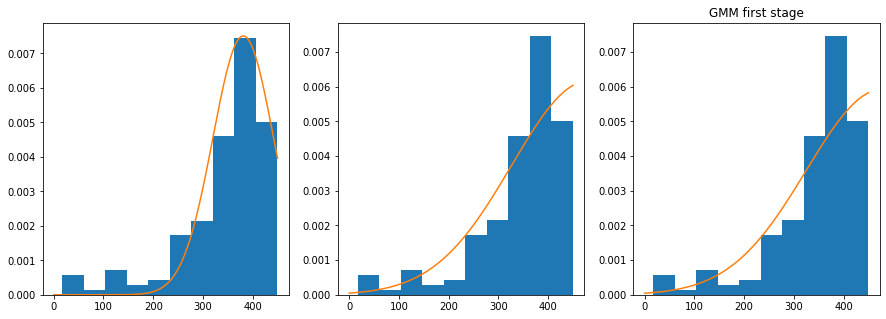

In [32]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15,5))

ax1.hist(pts,density = True)
ax1.plot(x1,y1)


ax2.hist(pts,density = True)
ax2.plot(x1,y2)


ax3.hist(pts,density = True)
ax3.plot(x1,y3)
ax3.set_title("GMM first stage")

In [33]:
# calculate the W opt

err1=gt(pts,a1.x[0],a1.x[1],cutoff)

omega = np.dot(err1, err1.T) / pts.shape[0]
W_2 = np.linalg.inv(omega)

In [34]:
err1=gt(pts,a1.x[0],a1.x[1],cutoff)
np.dot(err1, err1.T)

array([[8.17375721e-08, 4.84612378e-10],
       [4.84612378e-10, 2.87320935e-12]])

In [35]:
omega

array([[5.07686783e-10, 3.01001477e-12],
       [3.01001477e-12, 1.78460208e-14]])

In [36]:
W_2

array([[ 1.85206401e+25, -3.12380003e+27],
       [-3.12380003e+27,  5.26878474e+29]])

In [37]:
#second stage GMM
initial_guess = (500,100)
W_hat = W_2
gmm_args = (pts, W_hat,450)
a2=scipy.optimize.minimize(critial,initial_guess,gmm_args,method='L-BFGS-B')

C:\Users\Z4174\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  after removing the cwd from sys.path.
C:\Users\Z4174\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  import sys


In [38]:
a2.x

array([482.10189468, 155.98289222])

In [414]:
from sklearn.preprocessing import normalize
normed_matrix = normalize(W_2, axis=1, norm='l1')

initial_guess = (500,100,450)
W_hat = normed_matrix
gmm_args = (pts, W_hat)
a3=scipy.optimize.minimize(critial,initial_guess,gmm_args,method='L-BFGS-B')
a3.x

C:\Users\Z4174\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  after removing the cwd from sys.path.
C:\Users\Z4174\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  import sys


array([505.15653395,  80.35187103, 444.67447789])

In [407]:
G = gt(pts,383,116,478)
result=np.dot(np.dot(G.T , -W_2),G)
print(result)

[[8.31535638e+34]]
